<a href="https://colab.research.google.com/github/nkasmanoff/nasa_harvest_challenge/blob/main/Model_Training_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction


This notebook contains the final combination of the training and evalutation techniques I used to create a segmentation model capable of distinguishing between crop boundary lines based on the dataset provided by the NASA Harvest challenge. 


## Imports 

In [ ]:
# create the dataset
from google.colab import drive
drive.mount('/content/drive')
IMAGE_PATH = "/content/drive/MyDrive/data"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pip install -qq -U rasterio diffusers

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
import torch
import torchvision
from torch import nn
import numpy as np
import random 
from tqdm import tqdm
import os
import rasterio
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import Dataset
from torchvision import transforms
import scipy
import torch.nn.functional as F
from torch.nn import init
import pandas as pd
from sklearn.metrics import confusion_matrix, recall_score, average_precision_score

from skimage import filters

import torchvision.transforms as T
erase_transform = T.RandomErasing(p=0.75, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


# Experimental Setup

To set up this PyTorch model, I defined the following dataset and helper functions. The basic idea behind them is to return a given satellite image, along with the corresponding boundary lines. 

The following adjustments were added by me to help make training a bit more stable:

- Channelwise mean and standard deviations based on season of input image. 

- An "extent mask" for the same image
 - Rather than only have the oultine of the boundaries filled with 1's, each unique field is filled with the positive class. 

- An "easy mask" for the same image 
  - This was a gaussian blur applied to the output mask, with the intent of making the output image less sparse, but still retaining some important information as to the location of the boundary.


The idea behind adding these new outputs is that by casting this problem into a multi-task learning problem, these new tasks effectively serve as a new form of regularization for training, thus leading to better generalization. 



In [ ]:
def get_observation_dataset(observations,tile_list):
  ## Helper function meant to parse the list of observation tiles provided, returning what the unique tile # is.
  ## given a list of full input image names, return a list of what tiles they are.
    obs_data = []
    for obs in observations:
        if obs.startswith('n'):
            tile = obs.split('_')[-3]
            if int(tile) in tile_list:
                obs_data.append(obs)
    return obs_data        



def flood_fill(image, x, y, new_color):
  ## Fill the inside of the boundary fields with 1s, yielding an extent mask
  old_color = image[x][y]
  if old_color == new_color:
    return image

  stack = [(x, y)]
  image = image.copy()
  while stack:
    x, y = stack.pop()
    if image[x][y] == old_color:
      image[x][y] = new_color
      if x > 0:
        stack.append((x-1, y))
      if y > 0:
        stack.append((x, y-1))
      if x < len(image) - 1:
        stack.append((x+1, y))
      if y < len(image[0]) - 1:
        stack.append((x, y+1))

  return image




class BoundaryDataset(Dataset):
    def __init__(self, img_dir,rotate, flip, blur_input,color_jitter_image, tile_list, return_tiles = False):
        self.img_dir = img_dir
        self.tile_list = tile_list
        self.train_source_path = os.path.join(img_dir,'nasa_rwanda_field_boundary_competition_source_train')
        self.train_labels_path = os.path.join(img_dir,'nasa_rwanda_field_boundary_competition_labels_train')
        self.train_observations = os.listdir(self.train_source_path)
        self.train_observations = get_observation_dataset(self.train_observations,tile_list)
        self.return_tiles = return_tiles
        # shuffle the array
        np.random.shuffle(self.train_observations)

        self.rotate = rotate
        self.flip = flip
        self.blur_input = blur_input
        self.color_jitter_image = color_jitter_image


        self.ch_means = {'12': {0: 431.3529824393136,
                                1: 788.7664332798549,
                                2: 807.3898960658482,
                                3: 3107.176953125},
                              '08': {0: 474.95524117606027,
                                1: 822.4405508858817,
                                2: 976.0225524902344,
                                3: 2844.7081124441966},
                              '04': {0: 578.2920144217355,
                                1: 902.3028058733258,
                                2: 940.4450936453683,
                                3: 3050.7463309151785},
                              '10': {0: 464.1556418282645,
                                1: 818.5369105747768,
                                2: 900.1843279157366,
                                3: 3007.8089599609375},
                              '03': {0: 511.0887481689453,
                                1: 847.5952924455916,
                                2: 848.871928187779,
                                3: 3051.279038783482},
                              '11': {0: 445.8130131312779,
                                1: 794.7714381626674,
                                2: 810.068403843471,
                                3: 3114.7975655691966}}

        self.ch_stds = {'12': {0: 54.92225319998605,
                                1: 83.55576046534946,
                                2: 110.16008731297084,
                                3: 463.1466609409877},
                              '08': {0: 64.87839317321777,
                                1: 84.32121156964983,
                                2: 179.02223074776785,
                                3: 357.0686700003488},
                              '04': {0: 79.24656088692801,
                                1: 90.4365421295166,
                                2: 112.97693693978447,
                                3: 411.4854043143136},
                              '10': {0: 55.00247941698347,
                                1: 79.44168951851981,
                                2: 137.79774834769114,
                                3: 407.948571559361},
                              '03': {0: 60.84664066859654,
                                1: 64.75320674351283,
                                2: 97.44571881975446,
                                3: 298.10662285940987},
                              '11': {0: 53.32975948878697,
                                1: 71.6055459703718,
                                2: 113.14200733729771,
                                3: 373.70143149239675}}




    def __len__(self):
        return len(self.train_observations)
    
    def __getitem__(self, idx):
        observation = self.train_observations[idx]
        month = observation.split('_')[-1]
        observation_b01 = os.path.join(self.train_source_path,observation,'B01.tif')
        observation_b02 = os.path.join(self.train_source_path,observation,'B02.tif')
        observation_b03 = os.path.join(self.train_source_path,observation,'B03.tif')
        observation_b04 = os.path.join(self.train_source_path,observation,'B04.tif')

        observation_tile = observation.split('_')[-3]
        train_mask = os.path.join(self.train_labels_path,f'nasa_rwanda_field_boundary_competition_labels_train_{observation_tile}/raster_labels.tif')



        b01 = rasterio.open(observation_b01).read()
        b02 = rasterio.open(observation_b02).read()
        b03 = rasterio.open(observation_b03).read()
        b04 = rasterio.open(observation_b04).read()

        x = torch.stack([torch.tensor(b01[0].astype(np.float32)),
                torch.tensor(b02[0].astype(np.float32)),
                torch.tensor(b03[0].astype(np.float32)),
                torch.tensor(b04[0].astype(np.float32)),
                ])
               

        for ch in range(x.shape[0]):

          mean = self.ch_means[month][ch]
          std = self.ch_stds[month][ch]

          x[ch] = (x[ch] - mean) / std

        mask = torch.tensor(rasterio.open(train_mask).read().astype(np.float32))

        if self.blur_input:
          if random.random() > .5:
            kernel_size = random.choice([3,5])
            x = transforms.functional.gaussian_blur(x,kernel_size=kernel_size)          



        if self.flip:
          if random.random() > .5:
            x = transforms.functional.hflip(x)
            mask = transforms.functional.hflip(mask)
          if random.random() > .5:
            x = transforms.functional.vflip(x)
            mask = transforms.functional.vflip(mask)      


        if self.rotate:
          if random.random() > .25:
            angle = random.randint(-7,7) 
            x = transforms.functional.rotate(x, angle)
            mask = transforms.functional.rotate(mask, angle)



        arr = mask[0].numpy().copy()
        extent_mask  = flood_fill(arr,0,0,2)
        extent_mask = flood_fill(extent_mask,255,0,2)
        extent_mask = flood_fill(extent_mask,0,255,2)
        extent_mask = flood_fill(extent_mask,255,255,2)
        extent_mask[extent_mask == 0] = 3
        extent_mask[extent_mask == 1] = 1.
        extent_mask[extent_mask == 2] = 0.
        extent_mask[extent_mask == 3] = 1.
        extent_mask = torch.tensor(extent_mask).unsqueeze(0)

        easy_mask = transforms.functional.gaussian_blur(mask,kernel_size=75)          

        if self.return_tiles:

          return x, mask, extent_mask, easy_mask, observation_tile
        

        return x, mask, extent_mask, easy_mask


In [ ]:
RANDOM_SEED = 999
np.random.seed(RANDOM_SEED)

valid_split = .05
num_tiles = 57
tile_nums = np.arange(0,num_tiles)
valid_tiles = np.random.choice(num_tiles, int(round(valid_split*num_tiles)))
train_tiles = [x for x in tile_nums if x not in valid_tiles]

train_dataset = BoundaryDataset(img_dir=IMAGE_PATH,rotate=True,flip=True, blur_input=True, color_jitter_image=False ,tile_list=train_tiles)
valid_dataset = BoundaryDataset(img_dir=IMAGE_PATH,rotate=False,flip=False, blur_input = False, color_jitter_image = False, return_tiles=True ,tile_list=valid_tiles)


## Visualize a few inputs

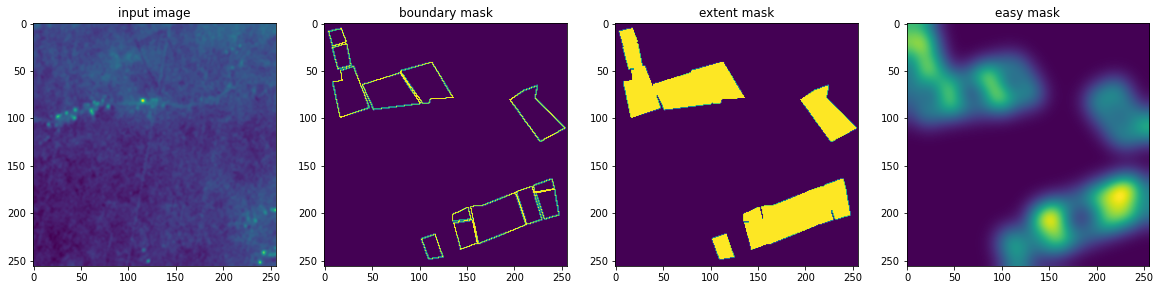

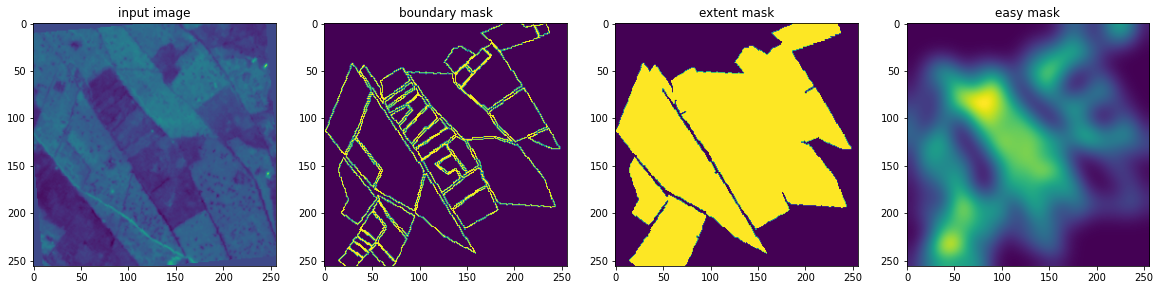

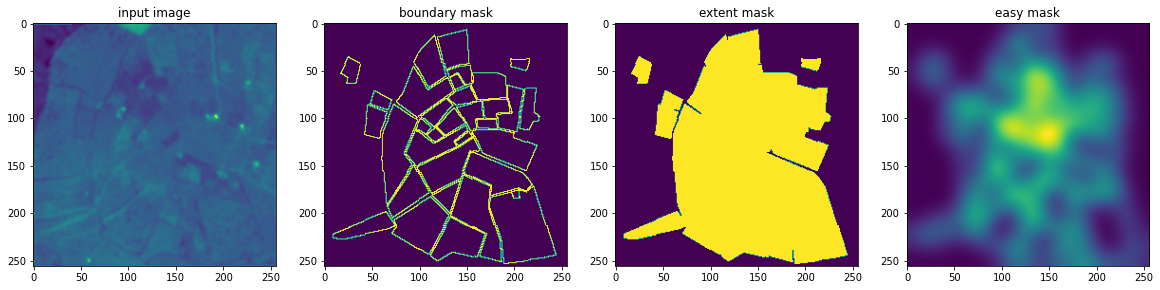

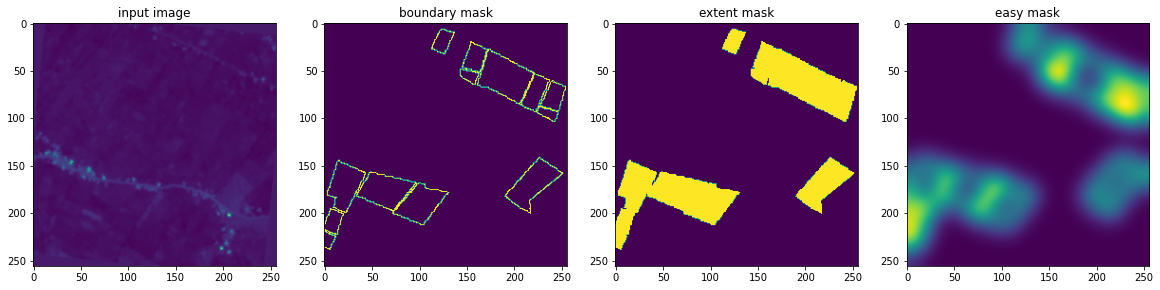

In [ ]:
for i in range(4):
  plt.figure(figsize=(20,5))
  x, mask, extent_mask, easy_mask = train_dataset.__getitem__(i)
  
  plt.subplot(141)
  plt.title('input image')
  plt.imshow(x.mean(dim=0))

  plt.subplot(142)
  plt.title('boundary mask')
  plt.imshow(mask[0])

  plt.subplot(143)
  plt.title('extent mask')
  plt.imshow(extent_mask[0])

  plt.subplot(144)
  plt.title('easy mask')
  plt.imshow(easy_mask[0])

## Defining the model

For this I went with a reliable implementation of a U-Net architecture, knowing that these model variations are usually well suited for segmentation tasks. To get this up and running as quick as possible, I am grateful to have found [this repository](https://github.com/LeeJunHyun/Image_Segmentation), which I used to quickly try many different kinds of U-Nets.

After some trial & error, the exact model I went with was a variation of the Attention U-Net, with various modifications to it's capacity, depth, and # of output channels. 

In [ ]:


class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

        



class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi


class AttU_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1,capacity_factor=1, expanded_bottleneck = True):
        super(AttU_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64*capacity_factor)
        self.Conv2 = conv_block(ch_in=64*capacity_factor,ch_out=128*capacity_factor)
        self.Conv3 = conv_block(ch_in=128*capacity_factor,ch_out=256*capacity_factor)
        self.Conv4 = conv_block(ch_in=256*capacity_factor,ch_out=512*capacity_factor)
        self.Conv5 = conv_block(ch_in=512*capacity_factor,ch_out=1024*capacity_factor)
        self.expanded_bottleneck = expanded_bottleneck
        if self.expanded_bottleneck:
          self.ConvBottleneck = conv_block(ch_in=1024*capacity_factor,ch_out=1024*capacity_factor)

        self.Dropout = nn.Dropout2d(p=0.5)
        self.Up5 = up_conv(ch_in=1024*capacity_factor,ch_out=512*capacity_factor)
        self.Att5 = Attention_block(F_g=512*capacity_factor,F_l=512*capacity_factor,F_int=256*capacity_factor)
        self.Up_conv5 = conv_block(ch_in=1024*capacity_factor, ch_out=512*capacity_factor)

        self.Up4 = up_conv(ch_in=512*capacity_factor,ch_out=256*capacity_factor)
        self.Att4 = Attention_block(F_g=256*capacity_factor,F_l=256*capacity_factor,F_int=128*capacity_factor)
        self.Up_conv4 = conv_block(ch_in=512*capacity_factor, ch_out=256*capacity_factor)
        
        self.Up3 = up_conv(ch_in=256*capacity_factor,ch_out=128*capacity_factor)
        self.Att3 = Attention_block(F_g=128*capacity_factor,F_l=128*capacity_factor,F_int=64*capacity_factor)
        self.Up_conv3 = conv_block(ch_in=256*capacity_factor, ch_out=128*capacity_factor)
        
        self.Up2 = up_conv(ch_in=128*capacity_factor,ch_out=64*capacity_factor)
        self.Att2 = Attention_block(F_g=64*capacity_factor,F_l=64*capacity_factor,F_int=32*capacity_factor)
        self.Up_conv2 = conv_block(ch_in=128*capacity_factor, ch_out=64*capacity_factor)

        self.Final_Conv_Block = conv_block(ch_in=64*capacity_factor,ch_out=64*capacity_factor)

        self.Final_Conv_Block_boundary_mask = conv_block(ch_in=64*capacity_factor,ch_out=64*capacity_factor)


        self.Final_Conv_Block_reconstruct_input = conv_block(ch_in=64*capacity_factor,ch_out=64*capacity_factor)
        self.Final_Conv_Block_extent_mask = conv_block(ch_in=64*capacity_factor,ch_out=64*capacity_factor)

        self.Conv_1x1_boundary_mask = nn.Conv2d(64*capacity_factor,output_ch,kernel_size=1,stride=1,padding=0)
        self.Conv_1x1_reconstuct_input = nn.Conv2d(64*capacity_factor,output_ch,kernel_size=1,stride=1,padding=0)
        self.Conv_1x1_extent_mask = nn.Conv2d(64*capacity_factor,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        if self.expanded_bottleneck:
          x_bottleneck = self.ConvBottleneck(x5)
          d5 = self.Up5(x_bottleneck)

        else:
          d5 = self.Up5(x5)

        x4 = self.Att5(g=d5,x=x4)

        d5 = torch.cat((x4,d5),dim=1)        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d2 = self.Final_Conv_Block(d2)
        d2_boundary_mask = self.Final_Conv_Block_boundary_mask(d2)
        d1_boundary_mask = self.Conv_1x1_boundary_mask(d2_boundary_mask)
        
        d2_reconstruct = self.Final_Conv_Block_reconstruct_input(d2)
        d1_reconstruct = self.Conv_1x1_reconstuct_input(d2_reconstruct)

        d2_extent_mask = self.Final_Conv_Block_extent_mask(d2)
        d1_extent_mask = self.Conv_1x1_extent_mask(d2_extent_mask)

        return d1_boundary_mask, torch.sigmoid(d1_boundary_mask), d1_reconstruct, d1_extent_mask, torch.sigmoid(d1_extent_mask)

## Defining loss functions

It is best practice in image segementation, especially in imbalanced data scenarios, to select a loss function beyond cross-entropy. 

A common alternative selection is Dice Loss, or a combination of Dice Loss and Cross-Entropy. Implementations of these are graciously pulled from [this notebook](https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook#Dice-Loss
), with some modifications to better combat sparsity. 

DiceBCE loss, with the added weight penalty applied to positive classes, was the criterion used for training the boundary mask task, while traditional Dice loss was applied for training the extent mask task. The easy mask was optimized using mean square error. 


In [ ]:
class DiceBCELoss(nn.Module):
  def __init__(self, weight=None, size_average=True):
      super(DiceBCELoss, self).__init__()
      self.weight = weight
      self.BCE = nn.BCEWithLogitsLoss(pos_weight = torch.tensor(self.weight).to(device)) 
  def forward(self, inputs, targets, smooth=1):
      

      BCE_loss = self.BCE(inputs,targets)
      inputs = torch.sigmoid(inputs)       
      
      inputs = inputs.view(-1)
      targets = targets.view(-1)
      
      intersection = (inputs * targets).sum()                            
      dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  

      Dice_BCE = BCE_loss + dice_loss
      
      return Dice_BCE


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        inputs = torch.sigmoid(inputs)       
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice


## Defining training and evaluation loops 

This competition is graded based on the model's f1-score on an held out dataset, meaning any models trained should be optimized for that objective. 

To accomplish this, in addition to training the models with the intent of minimizing validation loss, I also kept an eye on 2 other key metrics:

  - Average precision score
    - A very tricky part of this process is that even if a model is trained near perfectly, if an improper cutoff between the 0-1 class is chosen for thresholding at inference time, those results are moot. In an attempt to circumvent checking every single threshold, leading to a significant bottleneck, I employed [average precision score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html) to proxy this f1-value. 
  - F1-score
   - As another directional indication, I also applied an f1-score to the predictions across the validation set, with two important caveats. The threshold here likely is not the optimal one, and these predictions do not take into account the fact that these images should be combined to make predictions. Regardless, I took this as another bit of directional insight to guide the model training.

In [ ]:

def thresholded_f1(y_true, y_scores, threshold=.5):
    preds = torch.clone(y_scores)
    preds[preds <= threshold] = 0
    preds[preds > threshold] = 1

    return f1_score(y_true=y_true, y_pred=preds)


def train(model, train_dataloader, opt, loss_fn):
    epoch_losses = []
    epoch_f1_scores = []
    epoch_auc_values = []
    pixel_counts = []
    extent_loss_fn = DiceLoss()
    model.train();
    for x, y_boundary, y_extent, y_easy in tqdm(train_dataloader):

        boundary_mask_logits, boundary_mask_predicted_scores, reconstructed_input, extent_mask_logits, extent_mask_predicted_scores = model(x.to(device))
        boundary_loss = loss_fn(boundary_mask_logits,y_boundary.to(device))
        extent_loss = extent_loss_fn(extent_mask_logits,y_extent.to(device))
        reconstruction_loss = F.mse_loss(reconstructed_input, y_easy.to(device))
        loss = boundary_loss + extent_loss + reconstruction_loss
        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()
        # Store f1 and auc scores efficiently. 
        scores = boundary_mask_predicted_scores.detach().cpu().flatten()
        y_true = y_boundary.flatten().cpu()
        batch_pixels = y_true.shape[0]
        auc = average_precision_score(y_true=y_true,y_score=scores)
        f1_value = thresholded_f1(y_true,scores,threshold=.96)
       
        # Store the loss for later
        epoch_losses.append(loss.item())
        epoch_f1_scores.append(f1_value)
        epoch_auc_values.append(auc)
        pixel_counts.append(batch_pixels)

    batch_weights = np.divide(pixel_counts, sum(pixel_counts))
    avg_auc = sum(np.multiply(epoch_auc_values, batch_weights))
    avg_f1_score = sum(np.multiply(epoch_f1_scores, batch_weights))
    avg_loss = sum(np.multiply(epoch_losses, batch_weights))

    return epoch_losses, avg_loss, avg_auc, avg_f1_score


def validate(model, valid_dataloader,loss_fn):
    epoch_losses = []
    epoch_f1_scores = []
    epoch_auc_values = []
    pixel_counts = []
    

    model.train();
    with torch.no_grad():

      for x, y_boundary, y_extent, y_easy, tiles in tqdm(valid_dataloader):
        boundary_mask_logits, boundary_mask_predicted_scores, reconstructed_input, extent_mask_logits, extent_mask_predicted_scores = model(x.to(device))
        boundary_loss = loss_fn(boundary_mask_logits,y_boundary.to(device))

        loss = boundary_loss

        # Store f1 and auc scores efficiently. 
        scores = boundary_mask_predicted_scores.detach().cpu().flatten()
        y_true = y_boundary.flatten().cpu()
        batch_pixels = y_true.shape[0]
        auc = average_precision_score(y_true=y_true,y_score=scores) 
        f1_value = thresholded_f1(y_true,scores,threshold=.96)
        # Store the loss for later
        epoch_losses.append(loss.item())
        epoch_f1_scores.append(f1_value)
        epoch_auc_values.append(auc)
        pixel_counts.append(batch_pixels)


    batch_weights = np.divide(pixel_counts, sum(pixel_counts))
    avg_auc = sum(np.multiply(epoch_auc_values, batch_weights))
    avg_f1_score = sum(np.multiply(epoch_f1_scores, batch_weights))
    avg_loss = sum(np.multiply(epoch_losses, batch_weights))

    return avg_loss, avg_auc, avg_f1_score


# Training Loop

In [ ]:

# Create a model
model_name = 'AttU_Net' # @param


if model_name == 'AttU_Net':
  model = AttU_Net(img_ch = 4, output_ch=1,capacity_factor=2, expanded_bottleneck=False)

model.to(device);

LOSS_WEIGHT = 64
batch_size = 4 # @param
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

valid_dataloader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False
)


metric = 'val_loss' # @param
loss_approach = 'multi_task' # @param
AUC_PATH = f'/content/drive/MyDrive/data/submissions/{model_name}best_pr_auc_model_{loss_approach}_{RANDOM_SEED}_{LOSS_WEIGHT}.pt'
load_pretrained = False # @param
load_existing = False # @param
pretrained_PATH = f'/content/drive/MyDrive/data/submissions/{model_name}best_{metric}_model_pretrained_fill_middle.pt'

if load_pretrained and os.path.exists(pretrained_PATH):

  model.load_state_dict(torch.load(pretrained_PATH))
  model.train();
  print(pretrained_PATH, ' loaded!')

if load_existing and os.path.exists(AUC_PATH):

  model.load_state_dict(torch.load(AUC_PATH))
  model.train();
  print(AUC_PATH, ' loaded!')



In [ ]:

best_val_loss = 1e9
best_val_pr_auc = 0
opt = torch.optim.AdamW(model.parameters(), lr=5e-5,  weight_decay=1e-2) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode = 'min', factor=.25, patience=8)
loss_fn =   DiceBCELoss(weight=LOSS_WEIGHT)
n_epochs = 150
patience = 15
early_stop_epochs = 0
losses = []
f1_scores = []
val_losses = []
auc_values = []
for epoch in range(n_epochs):

    loss, avg_loss, avg_auc, avg_f1_score = train(model, train_dataloader, opt, loss_fn)
    avg_val_loss, avg_val_auc, avg_val_f1_score = validate(model, valid_dataloader, loss_fn)
    scheduler.step(avg_val_loss)
    losses.extend(loss)
    val_losses.append(avg_val_auc)
    print(f"Training {epoch} loss: {avg_loss} | PR auc: {avg_auc} | f1 {avg_f1_score}")
    print(f"Validation {epoch} loss: {avg_val_loss} | PR auc: {avg_val_auc} | f1 {avg_val_f1_score}")
    if avg_val_loss <= best_val_loss:
      print(f"New best loss achieved!")
      best_val_loss = avg_val_loss
      early_stop_epochs = 0
    if avg_val_auc > best_val_pr_auc: 
      print(f"New best auc achieved!")
      torch.save(model.state_dict(), AUC_PATH) # for the purposes of saving storage on Google Drive, I only save the model from the best average precision model.     
      best_val_pr_auc = avg_val_auc
      early_stop_epochs = 0
    else:
      early_stop_epochs += 1
    if early_stop_epochs > patience:
      print("Early stopping activated")
      break

100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


Training 0 loss: 3.655350081714583 | PR auc: 0.08723588162812843 | f1 0.0009771437471253932
Validation 0 loss: 3.202346934212579 | PR auc: 0.15515651049836288 | f1 0.0
New best loss achieved!
New best auc achieved!


100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


Training 1 loss: 3.317613951953841 | PR auc: 0.11895219447062232 | f1 0.00865492525744934
Validation 1 loss: 3.0299141671922465 | PR auc: 0.19020420362069484 | f1 0.011771690761861133
New best loss achieved!
New best auc achieved!


100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


Training 2 loss: 3.2294183513264585 | PR auc: 0.136314459338988 | f1 0.03527819776813588
Validation 2 loss: 2.997229046291775 | PR auc: 0.19933662427801369 | f1 0.017407432780548775
New best loss achieved!
New best auc achieved!


100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


Training 3 loss: 3.196584115793676 | PR auc: 0.14429137220172253 | f1 0.04603766933129478
Validation 3 loss: 2.9604780144161644 | PR auc: 0.20117455736687748 | f1 0.07866446200372616
New best loss achieved!
New best auc achieved!


100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


Training 4 loss: 3.1412225711492843 | PR auc: 0.15598439225259292 | f1 0.0789791464270231
Validation 4 loss: 2.9041722615559893 | PR auc: 0.22536317949470155 | f1 0.16876181051404662
New best loss achieved!
New best auc achieved!


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


Training 5 loss: 3.1226296483734486 | PR auc: 0.16407829274574076 | f1 0.10349824414550639
Validation 5 loss: 2.93110630247328 | PR auc: 0.21822356274309332 | f1 0.06710329133706694


100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


Training 6 loss: 3.0772863670631674 | PR auc: 0.1734702502561645 | f1 0.11276169170021703
Validation 6 loss: 2.8409218258327904 | PR auc: 0.24043906746669547 | f1 0.07343058660590282
New best loss achieved!
New best auc achieved!


100%|██████████| 5/5 [00:06<00:00,  1.40s/it]


Training 7 loss: 3.076943771338758 | PR auc: 0.17456243776283636 | f1 0.12050083933207294
Validation 7 loss: 2.8941962983873153 | PR auc: 0.22620737912664496 | f1 0.10174617248283307


100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


Training 8 loss: 3.057587567670846 | PR auc: 0.18438298943593978 | f1 0.1342190943969413
Validation 8 loss: 2.87568359904819 | PR auc: 0.23949064822262392 | f1 0.03220029760067846


100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


Training 9 loss: 3.022651651759206 | PR auc: 0.19325242037453008 | f1 0.15749886585853407
Validation 9 loss: 2.8364280859629307 | PR auc: 0.2565832364915287 | f1 0.17701518585975545
New best loss achieved!
New best auc achieved!


100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


Training 10 loss: 2.99512983251501 | PR auc: 0.19456962643723716 | f1 0.15372592536521545
Validation 10 loss: 2.8092138502332897 | PR auc: 0.24619835615260247 | f1 0.22454008371173242
New best loss achieved!


100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


Training 11 loss: 2.957231032995529 | PR auc: 0.20221646330520815 | f1 0.18544261281228339
Validation 11 loss: 2.839998642603556 | PR auc: 0.2442120647034826 | f1 0.10998295922767129


100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


Training 12 loss: 2.9529187002299735 | PR auc: 0.20227240309393946 | f1 0.1749308658046342
Validation 12 loss: 2.80390723546346 | PR auc: 0.24022189780657008 | f1 0.1452998682524675
New best loss achieved!


100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


Training 13 loss: 2.9263821884437844 | PR auc: 0.2061183133004225 | f1 0.19169492424025064
Validation 13 loss: 2.78336853451199 | PR auc: 0.2581785776919808 | f1 0.16271999969034617
New best loss achieved!
New best auc achieved!


100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


Training 14 loss: 2.9052517296355447 | PR auc: 0.21247211354942538 | f1 0.19084091508069537
Validation 14 loss: 2.884484873877631 | PR auc: 0.24918408052644753 | f1 0.09624551047327581


100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


Training 15 loss: 2.9062190203019127 | PR auc: 0.21109845694282617 | f1 0.1931639002972969
Validation 15 loss: 2.851844257778591 | PR auc: 0.25197029037339763 | f1 0.22473310351420228


100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


Training 16 loss: 2.876309780426967 | PR auc: 0.21409530315964995 | f1 0.186164560453167
Validation 16 loss: 2.7672157287597656 | PR auc: 0.27248279558889665 | f1 0.20236332279674005
New best loss achieved!
New best auc achieved!


100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


Training 17 loss: 2.832799917385901 | PR auc: 0.22343558531878818 | f1 0.22303078540730137
Validation 17 loss: 2.790077659818861 | PR auc: 0.25747418285922324 | f1 0.1511725607759288


100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


Training 18 loss: 2.845964355233275 | PR auc: 0.22325828808380635 | f1 0.21441670501442936
Validation 18 loss: 2.862568484412299 | PR auc: 0.24816476592688708 | f1 0.21583497311027613


100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


Training 19 loss: 2.824026496322065 | PR auc: 0.22757004642314188 | f1 0.2220307722489835
Validation 19 loss: 2.7790954907735186 | PR auc: 0.27016519858282456 | f1 0.12180401311859901


100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


Training 20 loss: 2.778159850909386 | PR auc: 0.23253489910989783 | f1 0.23134327177786032
Validation 20 loss: 2.785518142912123 | PR auc: 0.25980936407166244 | f1 0.26296572706618976


100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


Training 21 loss: 2.7630273265603162 | PR auc: 0.24208810311806678 | f1 0.25049364202429947
Validation 21 loss: 2.7883872985839844 | PR auc: 0.2793853113102572 | f1 0.23285435212613986
New best auc achieved!


100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


Training 22 loss: 2.7556644722267447 | PR auc: 0.23829511854224247 | f1 0.2439630011522737
Validation 22 loss: 2.8173128763834634 | PR auc: 0.2637659050226021 | f1 0.22919060833526592


100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


Training 23 loss: 2.7558705895035356 | PR auc: 0.23911055963146743 | f1 0.2482940399011977
Validation 23 loss: 2.7512396176656084 | PR auc: 0.2784020684883769 | f1 0.2518520851202369
New best loss achieved!


100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


Training 24 loss: 2.7460082931283085 | PR auc: 0.23703688767568606 | f1 0.251629199958223
Validation 24 loss: 2.8157605859968395 | PR auc: 0.2637750105497137 | f1 0.25780822244235985


100%|██████████| 5/5 [00:06<00:00,  1.40s/it]


Training 25 loss: 2.707601117499081 | PR auc: 0.24508830330331688 | f1 0.25693446953568505
Validation 25 loss: 2.7777834468417697 | PR auc: 0.2771190866420224 | f1 0.1573218768473953


100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


Training 26 loss: 2.7489211353254897 | PR auc: 0.24194303568267617 | f1 0.23922828569887158
Validation 26 loss: 2.744814819759793 | PR auc: 0.2852036055361568 | f1 0.28766806781974275
New best loss achieved!
New best auc achieved!


100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


Training 27 loss: 2.719845233140168 | PR auc: 0.24768548234246215 | f1 0.2672747620907962
Validation 27 loss: 2.8777692582872176 | PR auc: 0.2647587978840593 | f1 0.21612817164583642


100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


Training 28 loss: 2.710066945464524 | PR auc: 0.24458772605747178 | f1 0.25632287392765823
Validation 28 loss: 2.736905150943332 | PR auc: 0.3048891153852504 | f1 0.3099739784791586
New best loss achieved!
New best auc achieved!


100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


Training 29 loss: 2.7109978787692977 | PR auc: 0.24628719066375498 | f1 0.25238603166010537
Validation 29 loss: 2.8005168437957764 | PR auc: 0.2923298644487767 | f1 0.19587998605023263


100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


Training 30 loss: 2.6953369040548063 | PR auc: 0.25020479554717145 | f1 0.25988085153043367
Validation 30 loss: 2.696822828716702 | PR auc: 0.2999702892317913 | f1 0.2876068502976322
New best loss achieved!


100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


Training 31 loss: 2.651783878420606 | PR auc: 0.25208508072415703 | f1 0.2756902853927635
Validation 31 loss: 2.859459188249376 | PR auc: 0.26057031589345014 | f1 0.26886489135937414


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Training 32 loss: 2.6244714819354757 | PR auc: 0.2600984674205618 | f1 0.28066121230743535
Validation 32 loss: 2.7828291257222495 | PR auc: 0.288640624640668 | f1 0.286547037422331


100%|██████████| 5/5 [00:07<00:00,  1.60s/it]


Training 33 loss: 2.6351645110565936 | PR auc: 0.25575591684835614 | f1 0.27466303297124905
Validation 33 loss: 2.795755439334445 | PR auc: 0.28931916648880235 | f1 0.2915732126446203


100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


Training 34 loss: 2.610880689856445 | PR auc: 0.25947296304416095 | f1 0.2821303398133561
Validation 34 loss: 2.738242891099718 | PR auc: 0.30103708239595095 | f1 0.2844717630543736


100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


Training 35 loss: 2.6013430018483863 | PR auc: 0.2604802130694677 | f1 0.28332844525776607
Validation 35 loss: 2.810892422993978 | PR auc: 0.2769976295444216 | f1 0.29699227929915784


100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


Training 36 loss: 2.5785066316157197 | PR auc: 0.26279182323228406 | f1 0.2865301331250756
Validation 36 loss: 2.918120861053467 | PR auc: 0.28917974747084163 | f1 0.29790247379104606


100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


Training 37 loss: 2.5443443781063886 | PR auc: 0.26867452942835607 | f1 0.2919602800270773
Validation 37 loss: 2.8217247592078314 | PR auc: 0.29222048714512117 | f1 0.2864279458994107


100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


Training 38 loss: 2.53197455406189 | PR auc: 0.26916679708464847 | f1 0.3008172611181599
Validation 38 loss: 2.943399482303195 | PR auc: 0.2776020713534825 | f1 0.2812759102170643


100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


Training 39 loss: 2.5198720826043024 | PR auc: 0.2713274819747885 | f1 0.2980676280451415
Validation 39 loss: 3.1174696816338425 | PR auc: 0.2510862858318211 | f1 0.266314746411252


100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


Training 40 loss: 2.436983470563535 | PR auc: 0.28463423207772187 | f1 0.3216469691982463
Validation 40 loss: 3.011828316582574 | PR auc: 0.2862169225626341 | f1 0.30660124781785836


100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


Training 41 loss: 2.416091433277835 | PR auc: 0.2904254460017064 | f1 0.3261835347441274
Validation 41 loss: 2.953010082244873 | PR auc: 0.2973188262081113 | f1 0.3070055394167491


100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


Training 42 loss: 2.3702141694080674 | PR auc: 0.2941753432355324 | f1 0.32970409810899215
Validation 42 loss: 2.9531384309132895 | PR auc: 0.2930680843712528 | f1 0.2953150793359268


100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


Training 43 loss: 2.3540367918249996 | PR auc: 0.2957662472932522 | f1 0.3342191545482759
Validation 43 loss: 3.0717274877760143 | PR auc: 0.28694054985573947 | f1 0.30966655138167226


100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


Training 44 loss: 2.3167550254751132 | PR auc: 0.2988989106941013 | f1 0.33837652775156923
Validation 44 loss: 3.106164746814304 | PR auc: 0.2906046929898438 | f1 0.2930784347739156


100%|██████████| 5/5 [00:08<00:00,  1.61s/it]

Training 45 loss: 2.324190494454937 | PR auc: 0.29475697377209165 | f1 0.33209662852640165
Validation 45 loss: 3.05784453286065 | PR auc: 0.30362526564370174 | f1 0.3213698496949756
Early stopping activated


# Evaluation


With the best model trained, we can now look over it's predictions, identifying strengths and shortcomings to guide further training. 

In [ ]:
best_model = AttU_Net(img_ch = 4, output_ch=1, capacity_factor = 2, expanded_bottleneck = False)
best_model.to(device);
best_model.load_state_dict(torch.load(AUC_PATH))

<All keys matched successfully>

In [ ]:
boundary_valid_scores = []
boundary_valid_labels = []
extent_valid_scores = []
extent_valid_labels = []

valid_index = []
valid_tiles = []
for x, y_boundary, y_extent, y_easy_mask, tiles in tqdm(valid_dataloader):

  best_model.eval(); 
  with torch.no_grad():
      with torch.no_grad():
        boundary_mask_logits, boundary_mask_predicted_scores, reconstructed_input, extent_mask_logits, extent_mask_predicted_scores = best_model.forward(x.to(device))
 
  boundary_scores = boundary_mask_predicted_scores.detach().cpu().flatten().numpy().tolist()
  boundary_y_true = y_boundary.flatten().cpu().numpy().tolist()
  boundary_valid_scores.extend(boundary_scores)
  boundary_valid_labels.extend(boundary_y_true)
  valid_index.extend(np.arange(0,len(boundary_y_true)))
  valid_tiles.extend(tiles)
  scores = boundary_mask_predicted_scores.detach().cpu().flatten()
  y_true = y_boundary.flatten().cpu()

  f1_value = thresholded_f1(y_true,scores,threshold=.95)


  extent_scores = extent_mask_predicted_scores.detach().cpu().flatten().numpy().tolist()
  extent_y_true = y_extent.flatten().cpu().numpy().tolist()
  extent_valid_scores.extend(extent_scores)
  extent_valid_labels.extend(extent_y_true)






100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


In [ ]:
# Combined validation. 

# As alluded to, many of these images contain the same boundaries, but are over different months. 

# Starting now, we can begin to combine these different predictions to one, leading to insights as to what
# improvements this brings, and what aggregations strategies are best.


valid_df = pd.DataFrame()
valid_df['valid_scores'] = boundary_valid_scores
valid_df['valid_label'] = boundary_valid_labels

tiles_expanded = []
for tile in valid_tiles: 
  tiles_expanded.extend([tile for i in range(len(boundary_valid_scores) // len(valid_tiles))])
valid_df['tiles'] = tiles_expanded

valid_df['idx'] = valid_index

In [ ]:
# Evaluation the best f1-score based on a median aggregation strategy 
average_scores = valid_df.groupby(['tiles','idx']).median()['valid_scores'].values
true_labels = valid_df.groupby(['tiles','idx']).mean()['valid_label'].values
print("Evaluating best threshold for boundary mask")
best_f1 = 0
for threshold in np.arange(.9,1, .01):
  boundary_preds = np.copy(average_scores)
  boundary_preds[boundary_preds <= threshold] = 0
  boundary_preds[boundary_preds > threshold] = 1

  f1_value = f1_score(y_true=true_labels, y_pred=boundary_preds)
  if f1_value > best_f1:
    boundary_best_thresh = threshold
    best_f1 = f1_value
  print(threshold,f1_value)


Evaluating best threshold for boundary mask
0.9 0.38873710707269155
0.91 0.3929841856644075
0.92 0.3953100905723249
0.93 0.39517659183064135
0.9400000000000001 0.3892891526750669
0.9500000000000001 0.3767006399620763
0.9600000000000001 0.3514260431556735
0.9700000000000001 0.2971756697904737
0.9800000000000001 0.16504755917009756
0.9900000000000001 0.00438763830599008


In [ ]:
# Evaluation the best f1-score based on a maximum aggregation strategy 

average_scores = valid_df.groupby(['tiles','idx']).max()['valid_scores'].values
true_labels = valid_df.groupby(['tiles','idx']).mean()['valid_label'].values
print("Evaluating best threshold for boundary mask")
best_f1 = 0
for threshold in np.arange(.9,1, .01):
  boundary_preds = np.copy(average_scores)
  boundary_preds[boundary_preds <= threshold] = 0
  boundary_preds[boundary_preds > threshold] = 1

  f1_value = f1_score(y_true=true_labels, y_pred=boundary_preds)
  if f1_value > best_f1:
    boundary_best_thresh = threshold
    best_f1 = f1_value
  print(threshold,f1_value)


Evaluating best threshold for boundary mask
0.9 0.35619865445079274
0.91 0.367019546916212
0.92 0.37742925553659373
0.93 0.38879414657618583
0.9400000000000001 0.3978534158380988
0.9500000000000001 0.4017428576489133
0.9600000000000001 0.39430383036224725
0.9700000000000001 0.3657470881437156
0.9800000000000001 0.25600888534092286
0.9900000000000001 0.017062104168635978


In [ ]:
# Evaluation the best f1-score based on a average aggregation strategy 

average_scores = valid_df.groupby(['tiles','idx']).mean()['valid_scores'].values
true_labels = valid_df.groupby(['tiles','idx']).mean()['valid_label'].values
print("Evaluating best threshold for boundary mask")
best_f1 = 0
for threshold in np.arange(.9,1, .01):
  boundary_preds = np.copy(average_scores)
  boundary_preds[boundary_preds <= threshold] = 0
  boundary_preds[boundary_preds > threshold] = 1

  f1_value = f1_score(y_true=true_labels, y_pred=boundary_preds)
  if f1_value > best_f1:
    boundary_best_thresh = threshold
    best_f1 = f1_value
  print(threshold,f1_value)

Evaluating best threshold for boundary mask
0.9 0.38884972070068874
0.91 0.39281447062728175
0.92 0.39473307314977263
0.93 0.39426669780476414
0.9400000000000001 0.3887814106606526
0.9500000000000001 0.37639965546942294
0.9600000000000001 0.3506317132392279
0.9700000000000001 0.29530811302075727
0.9800000000000001 0.16363599422987057
0.9900000000000001 0.00438763830599008


In [ ]:
boundary_preds = np.copy(boundary_valid_scores)
boundary_preds[boundary_preds <= boundary_best_thresh] = 0
boundary_preds[boundary_preds > boundary_best_thresh] = 1

print(confusion_matrix(boundary_valid_labels, boundary_preds))

[[978791 116107]
 [ 38064  46686]]


In [ ]:
tn, fp, fn, tp = confusion_matrix(boundary_valid_labels, boundary_preds).ravel()
# number of items correctly identified as positive out of total actual positives.
print(tp / (tp + fn))

# number of items correctly identified as positive out of total items identified as positive
print(tp / (tp + fp))

0.5508672566371682
0.2867813726634438


In [ ]:
# define threshold for the extent mask, and visualize these predictions too.
extent_best_thresh = .6


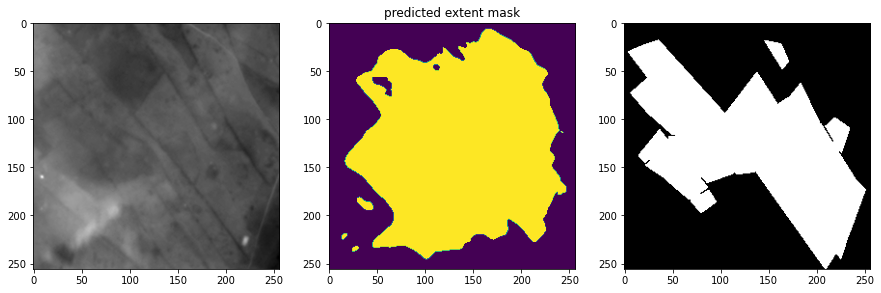

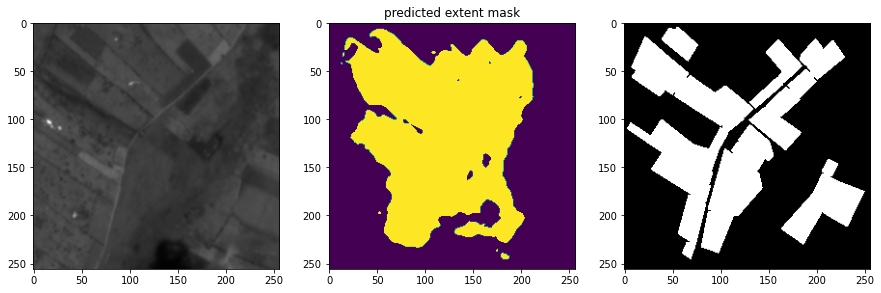

In [ ]:



for i in range(2):

  plt.figure(figsize = (15,5))
  plt.title('input image')
  plt.subplot(131)
  plt.imshow(x[i].mean(dim=0),cmap='gray')

  plt.subplot(132)
  plt.title('predicted extent mask')
  extent_pred_mask = extent_mask_predicted_scores[i][0].detach().cpu().numpy()
  extent_pred_mask[extent_pred_mask > extent_best_thresh] = 1
  extent_pred_mask[extent_pred_mask <= extent_best_thresh] = 0
  plt.imshow(extent_pred_mask)

  plt.subplot(133)
  plt.imshow(y_extent[i].mean(dim=0),cmap='gray')




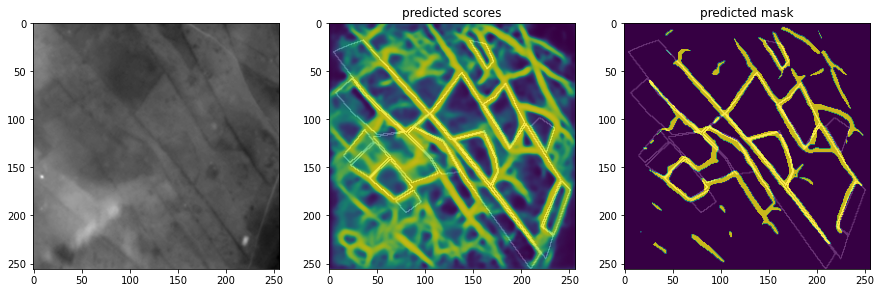

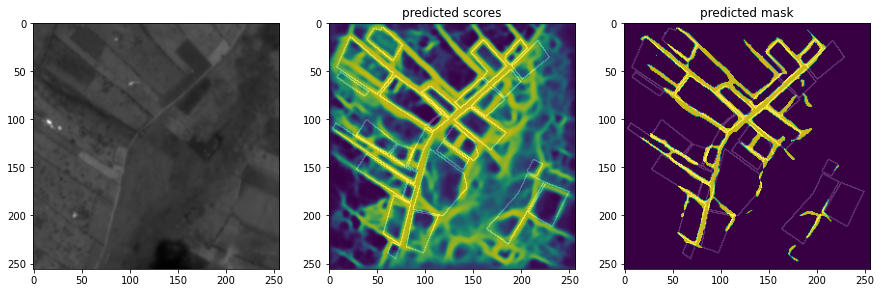

In [ ]:



for i in range(x.shape[0]):

  plt.figure(figsize = (15,5))
  plt.title('input image')
  plt.subplot(131)
  plt.imshow(x[i].mean(dim=0),cmap='gray')

  plt.subplot(132)
  plt.title('predicted scores')
  plt.imshow(boundary_mask_predicted_scores[i][0].detach().cpu().numpy())
  plt.imshow(y_boundary[i].mean(dim=0),cmap='gray',alpha=.2)

  plt.subplot(133)
  plt.title('predicted mask')
  boundary_pred_mask = boundary_mask_predicted_scores[i][0].detach().cpu().numpy()
  boundary_pred_mask[boundary_pred_mask > boundary_best_thresh] = 1
  boundary_pred_mask[boundary_pred_mask <= boundary_best_thresh] = 0
  plt.imshow(boundary_pred_mask)
  plt.imshow(y_boundary[i].mean(dim=0),cmap='gray',alpha=.2)



# Output Inference:

Please check out [my inference notebook](https://colab.research.google.com/drive/1wiX0eBLCFrPcMamPkdCaR7DHEMdkRHaC#scrollTo=tAZjIIwCkZAW), where an ensemble of multiple learners is used to produce inference masks.